In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skbio.stats.ordination import pcoa
from skbio.stats.distance import DistanceMatrix, permanova

In [34]:
import warnings

# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, 
                        message=".*is_categorical_dtype is deprecated.*")

In [24]:
def sort_dataframe(df):
    # Convert index and columns to integers, sort, and then convert back to strings
    df.index = df.index.astype(int)
    df.columns = df.columns.astype(int)
    df = df.sort_index().sort_index(axis=1)
    df.index = df.index.astype(str)
    df.columns = df.columns.astype(str)
    return df

In [28]:
# Load distance matrices
its_bc_df = pd.read_csv('ITS/bray-curtis/distance-matrix.tsv', sep='\t', index_col=0)
its_jac_df = pd.read_csv('ITS/exported-jaccard/distance-matrix.tsv', sep='\t', index_col=0)
amf_bc_df = pd.read_csv('18S/exported-bray-curtis/distance-matrix.tsv', sep='\t', index_col=0)
amf_jac_df = pd.read_csv('18S/exported-jaccard/distance-matrix.tsv', sep='\t', index_col=0)

# Sort the dataframes
its_bc_df = sort_dataframe(its_bc_df)
its_jac_df = sort_dataframe(its_jac_df)
amf_bc_df = sort_dataframe(amf_bc_df)
amf_jac_df = sort_dataframe(amf_jac_df)

# Load the mapping file
mapping_file = pd.read_csv('mapping_file.tsv', sep='\t', skiprows=[1])
mapping_file = mapping_file[mapping_file['fire'] != 'mu']

In [36]:
def perform_and_plot_pcoa(df, title, ax, color_by='fire'):
    # Convert DataFrame to a C-contiguous NumPy array
    contiguous_array = df.values.copy()

    # Convert indices in the distance matrix to string if they are not
    df.index = df.index.map(str)

    # Ensure indices match between distance matrix and mapping file
    # Convert 'sampleid' in mapping file to string
    mapping_file['sampleid'] = mapping_file['sampleid'].map(str)
    common_indices = df.index.intersection(mapping_file['sampleid'])

    # Filter the distance matrix and mapping file by common indices
    df_filtered = df.loc[common_indices, common_indices]
    mapping_file_filtered = mapping_file[mapping_file['sampleid'].isin(common_indices)]

    # Ensure that the dataframes have the same set of indices
    df_filtered = df_filtered[df_filtered.index.isin(mapping_file_filtered['sampleid'])]
    df_filtered = df_filtered.loc[:, df_filtered.columns.isin(mapping_file_filtered['sampleid'])]
    mapping_file_filtered = mapping_file_filtered[mapping_file_filtered['sampleid'].isin(df_filtered.index)]

    # Recreate the contiguous array with the filtered data
    contiguous_array = df_filtered.values.copy()

    # Perform PCoA
    pcoa_results = pcoa(DistanceMatrix(contiguous_array, df_filtered.index))

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame(data=pcoa_results.samples, index=df_filtered.index)
    plot_df = plot_df.merge(mapping_file_filtered, left_index=True, right_on='sampleid')

    # Perform PERMANOVA
    perma_results = permanova(DistanceMatrix(contiguous_array, df_filtered.index), 
                              grouping=plot_df[color_by], permutations=999)

    # Plotting
    sns.scatterplot(x='PC1', y='PC2', hue=color_by, data=plot_df, ax=ax, palette='Set2')
    ax.set_title(f'{title}\nPERMANOVA: F={perma_results["test statistic"]:.2f}, p={perma_results["p-value"]:.3f}')
    ax.legend(title=color_by, loc='upper right')

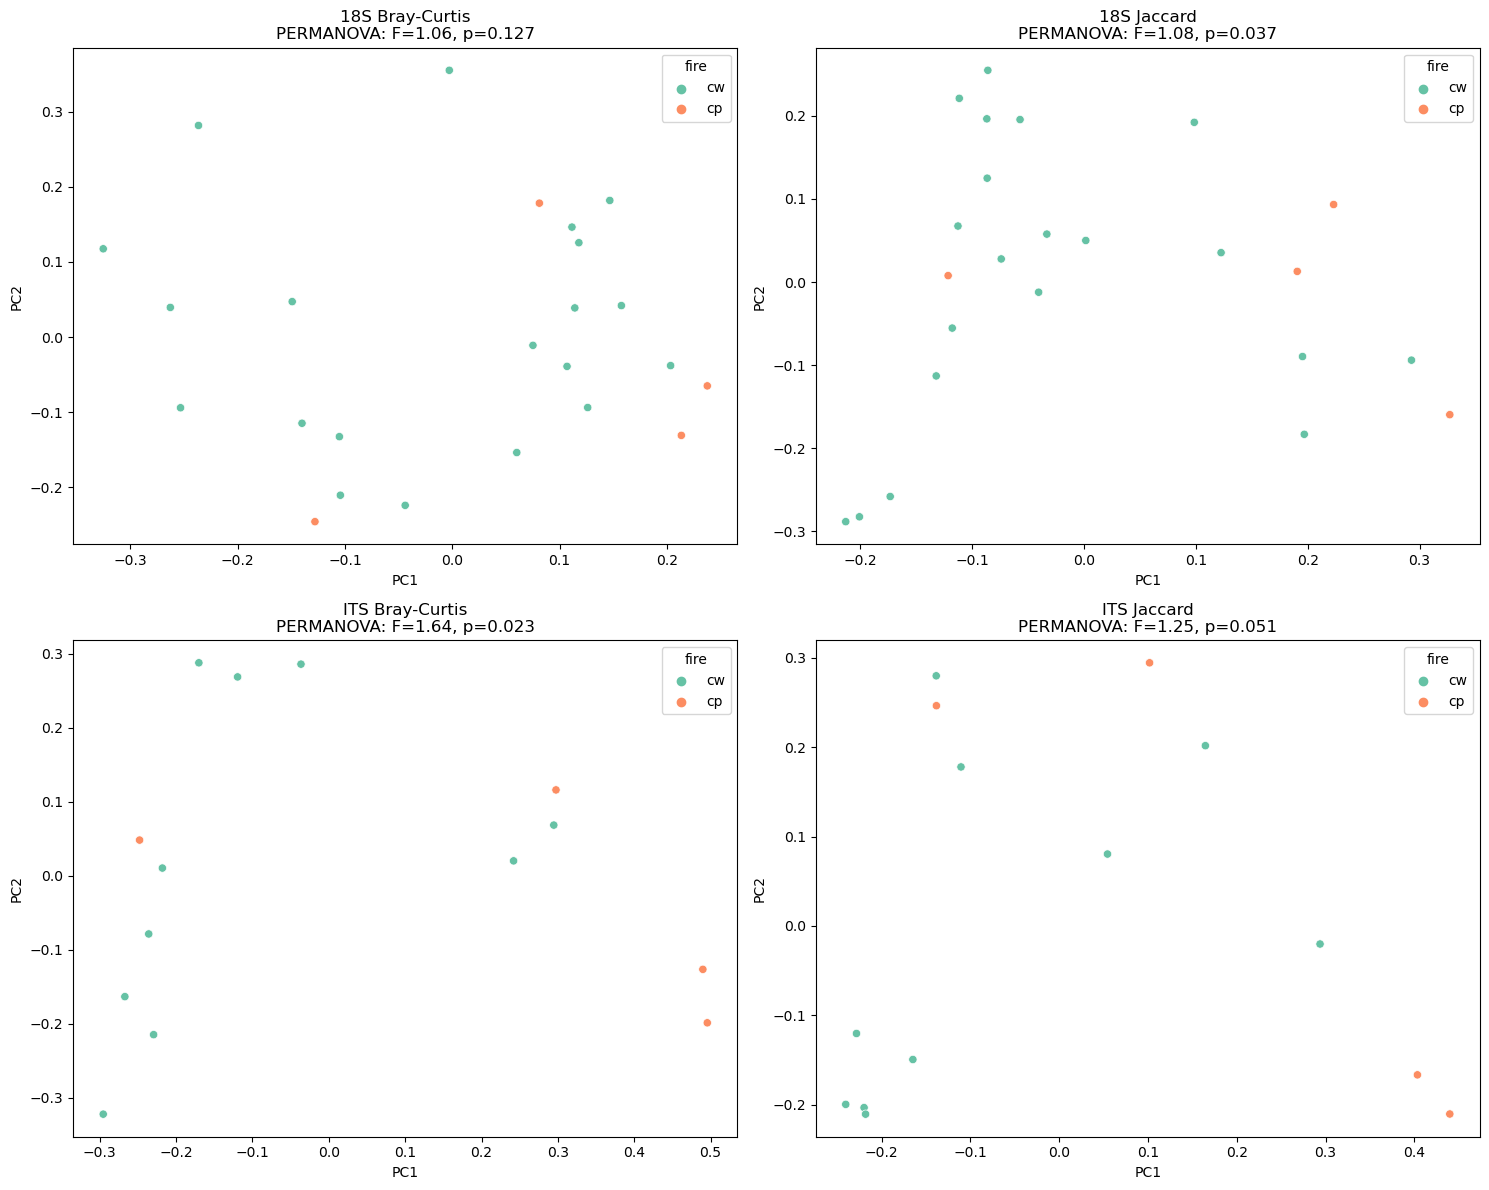

In [37]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Plot each dataset
perform_and_plot_pcoa(amf_bc_df, '18S Bray-Curtis', axs[0, 0])
perform_and_plot_pcoa(amf_jac_df, '18S Jaccard', axs[0, 1])
perform_and_plot_pcoa(its_bc_df, 'ITS Bray-Curtis', axs[1, 0])
perform_and_plot_pcoa(its_jac_df, 'ITS Jaccard', axs[1, 1])

plt.tight_layout()
plt.savefig('Figures/ordination_plots_by_fire.jpg', dpi=300)
plt.show()